In [1]:
import numpy as np

import pandas as pd

import cv2

import matplotlib.pyplot as plt

import skimage.io as io

import skimage as sk

from skimage.feature import greycomatrix, greycoprops
from skimage import data
from scipy.signal import convolve2d


In [32]:
image = cv2.imread('ACdata_base/1/0001.jpg')
names = np.loadtxt("ACdata_base/names.txt", dtype=str)

In [33]:
def show_images(images,titles=None):
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

def PreProcessing(img):
    
    # (1) RGB to Gray
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # (2) threshold
    th, threshed = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    pts = cv2.findNonZero(threshed)
    ret = cv2.minAreaRect(pts)
    
    #The data has a correct orientation already.
    '''
    # (3) minAreaRect on the nonzeros
    H, W = img.shape[:2]
    (cx, cy), (w, h), ang = ret

    if (H > W and w > h) or (H < W and w < h):
        w, h = h, w
        ang += 90

    # (4) Find rotated matrix, do rotation
    M = cv2.getRotationMatrix2D((cx, cy), ang, 1.0)
    rotated = cv2.warpAffine(threshed, M, (img.shape[1], img.shape[0]))

    # (5) find and draw the upper and lower boundary of each lines
    hist = cv2.reduce(rotated, 1, cv2.REDUCE_AVG).reshape(-1)
    th = 2
    upper = [y for y in range(H-1) if hist[y] <= th and hist[y+1] > th]
    lower = [y for y in range(H-1) if hist[y] > th and hist[y+1] <= th]
    
    line = []
    line.append(rotated[upper[0]-5:lower[0]+5, :])
    '''
    return [threshed]

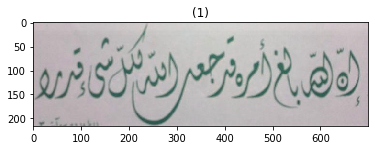

In [34]:
show_images([image])

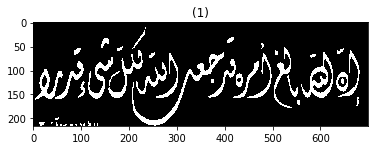

In [35]:
line = PreProcessing(image)
show_images(line)

In [44]:
def lpq(img,winSize=3,freqestim=1,mode='im'):
    rho=0.90

    STFTalpha=1/winSize  # alpha in STFT approaches (for Gaussian derivative alpha=1)
    sigmaS=(winSize-1)/4 # Sigma for STFT Gaussian window (applied if freqestim==2)
    sigmaA=8/(winSize-1) # Sigma for Gaussian derivative quadrature filters (applied if freqestim==3)

    convmode='valid' # Compute descriptor responses only on part that have full neigborhood. Use 'same' if all pixels are included (extrapolates np.image with zeros).

    img=np.float64(img) # Convert np.image to double
    r=(winSize-1)/2 # Get radius from window size
    x=np.arange(-r,r+1)[np.newaxis] # Form spatial coordinates in window

    if freqestim==1:  #  STFT uniform window
        #  Basic STFT filters
        w0=np.ones_like(x)
        w1=np.exp(-2*np.pi*x*STFTalpha*1j)
        w2=np.conj(w1)

    ## Run filters to compute the frequency response in the four points. Store np.real and np.imaginary parts separately
    # Run first filter
    filterResp1=convolve2d(convolve2d(img,w0.T,convmode),w1,convmode)
    filterResp2=convolve2d(convolve2d(img,w1.T,convmode),w0,convmode)
    filterResp3=convolve2d(convolve2d(img,w1.T,convmode),w1,convmode)
    filterResp4=convolve2d(convolve2d(img,w1.T,convmode),w2,convmode)

    # Initilize frequency domain matrix for four frequency coordinates (np.real and np.imaginary parts for each frequency).
    freqResp=np.dstack([filterResp1.real, filterResp1.imag,
                        filterResp2.real, filterResp2.imag,
                        filterResp3.real, filterResp3.imag,
                        filterResp4.real, filterResp4.imag])

    ## Perform quantization and compute LPQ codewords
    inds = np.arange(freqResp.shape[2])[np.newaxis,np.newaxis,:]
    LPQdesc=((freqResp>0)*(2**inds)).sum(2)

    ## Switch format to uint8 if LPQ code np.image is required as output
    if mode=='im':
        LPQdesc=np.uint8(LPQdesc)
        plt.figure(figsize=(20,10))
        plt.subplot(121)
        plt.imshow(img, cmap='gray')
        plt.title("Original image")

        plt.subplot(122)
        plt.imshow(LPQdesc, cmap='gray')
        plt.title("lpq")
        plt.show()


    ## Histogram if needed
    if mode=='nh' or mode=='h':
        LPQdesc=np.histogram(LPQdesc.flatten(),range(256))[0]

    ## Normalize histogram if needed
    if mode=='nh':
        LPQdesc=LPQdesc/LPQdesc.sum()

    return LPQdesc

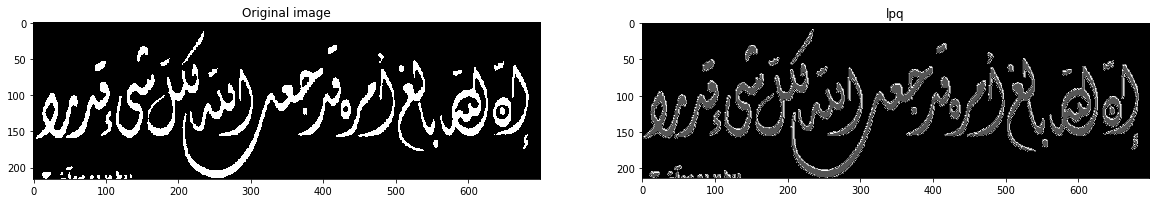

(214, 698)


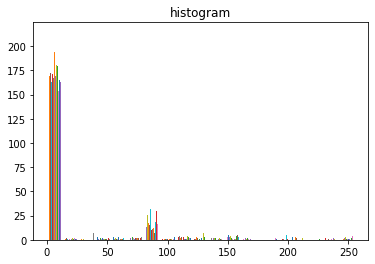

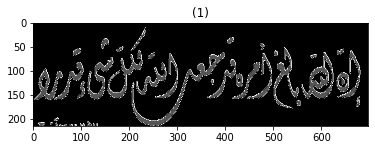

In [45]:
a = lpq(line[0])
print(a.shape)
plt.hist(a, bins='auto')
plt.title("histogram")
plt.show()
show_images([a])